<a href="https://colab.research.google.com/github/AliEmami89/ML/blob/main/Training_Performance_Measures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating the Dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Trainingg SGD Classifier

In [2]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [3]:
print(sgd_clf.predict(X_test[0:20]))
print(y_test[0:20])


[False False False False False False False False False False False False
 False False False  True False False False False]
['7' '2' '1' '0' '4' '1' '4' '9' '5' '9' '0' '6' '9' '0' '1' '5' '9' '7'
 '3' '4']


Training using k-fold Cross-validation

In [4]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Dummy Classifier

In [5]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [6]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

# **Confusion matrix**

In [7]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


In [9]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

For dummy classifier

In [10]:
y_train_pred_dummy = cross_val_predict(dummy_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred_dummy)

array([[54579,     0],
       [ 5421,     0]])

**Precision and Recall**

In [11]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (1891 + 3530)

0.8370879772350012
0.6511713705958311


In [12]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

For dummy classifier

In [13]:
print(precision_score(y_train_5, y_train_pred_dummy))
print(recall_score(y_train_5, y_train_pred_dummy))

0.0
0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**ROC curve**

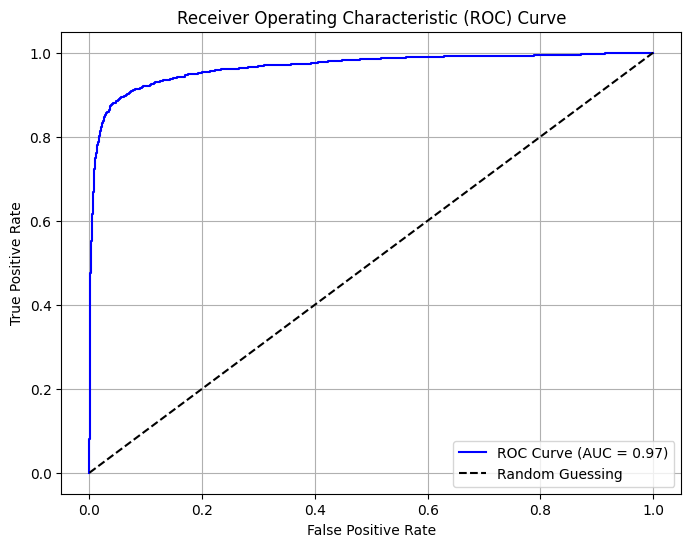

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the decision scores for the test set
y_scores = sgd_clf.decision_function(X_test)  # Use the decision function for scores

# Compute the true positive rate (tpr), false positive rate (fpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test_5, y_scores)

# Calculate the Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_test_5, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")  # Dashed diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Multilabel Classification**

In [15]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
print(y_multilabel)


[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


**KNN**

In [16]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Average F_1 score

In [17]:
from sklearn.metrics import f1_score

# Generate predictions for the test set
y_pred = knn_clf.predict(X_test)

y_test_large = (y_test >= '7')
y_test_odd = (y_test.astype('int8') % 2 == 1)
y_test_multilabel = np.c_[y_test_large, y_test_odd]

# Calculate the F_1 score for each label
f1_large = f1_score(y_test_multilabel[:, 0], y_pred[:, 0])
f1_odd = f1_score(y_test_multilabel[:, 1], y_pred[:, 1])

# Compute the average F₁ score
average_f1 = (f1_large + f1_odd) / 2

print(f"F_1 score for 'large label': {f1_large:.2f}")
print(f"F_1 score for 'odd label': {f1_odd:.2f}")
print(f"Average F_1 score: {average_f1:.2f}")

F_1 score for 'large label': 0.97
F_1 score for 'odd label': 0.99
Average F_1 score: 0.98


An Example: Image Noise Removal

In [18]:
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [19]:
import matplotlib.pyplot as plt

def plot_digit(data):
    """
    Plots a single digit image (28x28 grayscale) using matplotlib.
    """
    image = data.reshape(28, 28)  # Reshape flat data into 28x28
    plt.imshow(image, cmap="binary")  # Display the image in black and white
    plt.axis("off")  # Remove axes for cleaner visualization

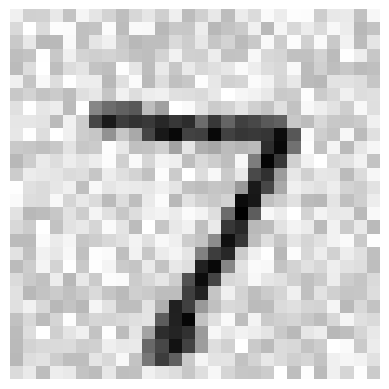

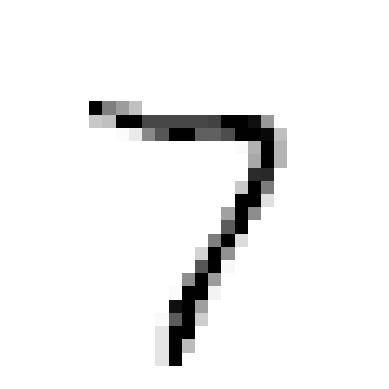

In [21]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod , y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(X_test_mod[0])
plt.show()
plot_digit(clean_digit)
plt.show()